In [1]:
#clone YOLOv5 and
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 16567, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16567 (delta 23), reused 31 (delta 13), pack-reused 16522
Receiving objects: 100% (16567/16567), 15.07 MiB | 9.06 MiB/s, done.
Resolving deltas: 100% (11376/11376), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.1/752.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_v7.0
requirements: YOLOv5 requirement "ipython" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.4 MB/s eta 0:00:00

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_v7.0/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2024-4-24 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


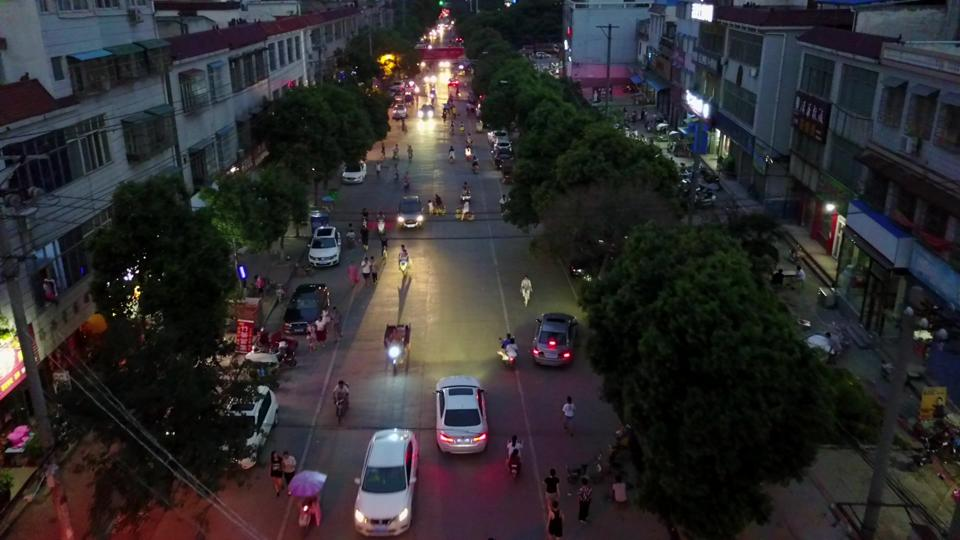

Cropped Region 1


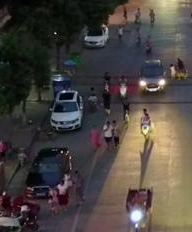

Cropped Region 2


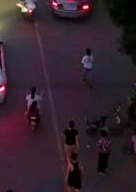

Cropped Region 3


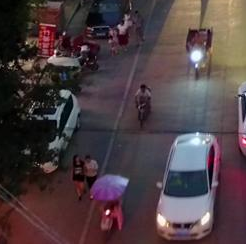

Cropped Region 4


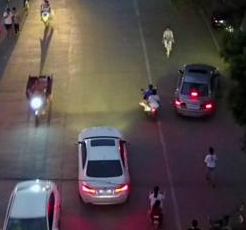

In [ ]:
#SARSA
import torch
from PIL import Image
from IPython.display import display, Image as IPImage
import numpy as np
from sklearn.cluster import KMeans
import time

# Load your custom-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5:v7.0', 'custom', path='/content/drive/MyDrive/yolov5/yolov5x.pt')

def transfrom_offsets(center, range, height_ori, width_ori):
    center_x = center[1]
    center_y = center[0]
    crop_width = range[1]
    crop_height = range[0]
    part_x1 = int(center_x - crop_width // 2)
    part_x2 = int(center_x + crop_width // 2)
    part_y1 = int(center_y - crop_height // 2)
    part_y2 = int(center_y + crop_height // 2)
    if part_x1 < 0 and part_x2 > width_ori:
        center_x = int(width_ori // 2)
        part_x1 = 0
        part_x2 = width_ori
    elif part_x1 < 0:
        offset_x = 0 - part_x1
        center_x += offset_x
        part_x1 += offset_x
        part_x2 += offset_x
        if part_x2 > width_ori:
            center_x += (width_ori - part_x2) / 2
            part_x2 = width_ori
    elif part_x2 > width_ori:
        offset_x = width_ori - part_x2
        center_x += offset_x
        part_x1 += offset_x
        part_x2 += offset_x
        if part_x1 < 0:
            center_x += (0 - part_x1) / 2
            part_x1 = 0
    if part_y1 < 0 and part_y2 > height_ori:
        center_y = int(height_ori // 2)
        part_y1 = 0
        part_y2 = height_ori
    elif part_y1 < 0:
        offset_y = 0 - part_y1
        center_y += offset_y
        part_y1 += offset_y
        part_y2 += offset_y
        if part_y2 > height_ori:
            center_y += (height_ori - part_y2) / 2
            part_y2 = height_ori
    elif part_y2 > height_ori:
        offset_y = height_ori - part_y2
        center_y += offset_y
        part_y1 += offset_y
        part_y2 += offset_y
        if part_y1 < 0:
            center_y += (0 - part_y1) / 2
            part_y1 = 0
    return part_x1, part_y1, part_x2, part_y2

def cluster_by_boxes_centers(cluster_num, image_size, boxes,
                             crop_size=300, padding_size=50, normalized_ratio=2, weight_with_area=False):
    start = time.time()
    center2boxes = {}
    X = []
    weighted_X = []
    for p in boxes:
        x = int(p[0] + p[2]) // 2
        y = int(p[1] + p[3]) // 2
        if [y, x] not in X:
            X.append([y, x])
        weight = int((p[2] - p[0]) * (p[3] - p[1])) // 400 + 1
        if weight_with_area:
            for w in range(weight):
                weighted_X.append([y, x])
        center2boxes[(y, x)] = p
    if len(X) == 0:
        return [], []
    ranges = [[] for i in range(cluster_num)]
    centers = [[] for i in range(cluster_num)]

    if len(X) < cluster_num:
        for i in range(cluster_num):
            if i < len(X):
                centers[i] = X[i]
            else:
                centers[i] = X[0]

            if crop_size <= 0:
                ranges[i] = [300, 300]
            else:
                ranges[i] = [crop_size, crop_size]
        return np.asarray(centers), np.asarray(ranges)
    if weight_with_area:
        X = np.asarray(weighted_X)
    else:
        X = np.asarray(X)
    kmeans = KMeans(n_clusters=cluster_num)
    classes = kmeans.fit(X)
    end = time.time()
    cost_time = end - start

    lbs = classes.labels_
    for i in range(cluster_num):
        inds = np.where(lbs == i)
        tmp_h = X[inds[0]][:, 0]
        tmp_w = X[inds[0]][:, 1]
        assert len(tmp_h) > 0, "X len: {},inds len: {}".format(len(X), len(inds[0]))
        list_h = []
        list_w = []
        for j, h in enumerate(tmp_h):
            w = tmp_w[j]
            box = center2boxes[(h, w)]
            list_w.append(box[0])
            list_w.append(box[2])
            list_h.append(box[1])
            list_h.append(box[3])
        min_h = min(list_h)
        max_h = max(list_h)
        min_w = min(list_w)
        max_w = max(list_w)
        max_height = max_h - min_h + padding_size
        max_width = max_w - min_w + padding_size
        ranges[i].append(max([max_height, max_width // normalized_ratio]))
        ranges[i].append(max([max_height // normalized_ratio, max_width]))
        centers[i] = [(min_h + max_h) // 2, (min_w + max_w) // 2]
    ranges = np.asarray(ranges).astype(np.int32)
    centers = np.asarray(centers).astype(np.int32)

    return centers, ranges


def self_adaptive_crop(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Perform inference with YOLOv5
    results = model(image)

    # Extract bounding box coordinates, class labels, and prediction scores
    bboxes = results.xyxy[0][:, :4].cpu().numpy()
    scores = results.xyxy[0][:, 4].cpu().numpy()

    # Combine bounding boxes and scores
    boxes_with_scores = np.column_stack((bboxes, scores))

    # Use self-adaptive cropping method
    centers, ranges = cluster_by_boxes_centers(4, image.size, boxes_with_scores)
    cropped_images = []

    for center, range in zip(centers, ranges):
        part_x1, part_y1, part_x2, part_y2 = transfrom_offsets(center, range, image.size[1], image.size[0])
        cropped_region = image.crop((part_x1, part_y1, part_x2, part_y2))
        cropped_images.append(cropped_region)

    return cropped_images

# Example usage
image_path = "/content/0000107_00891_d_0000052.jpg"  # Replace with your image path

# Process the image and get cropped regions
cropped_images = self_adaptive_crop(image_path)

# Display the original image
display(IPImage(filename=image_path))

# Display the cropped regions
for idx, cropped_region in enumerate(cropped_images):
    print(f"Cropped Region {idx + 1}")
    display(cropped_region)


In [ ]:
!pip install --upgrade Pillow


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_v7.0
YOLOv5 🚀 2024-4-24 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cropped Image 1


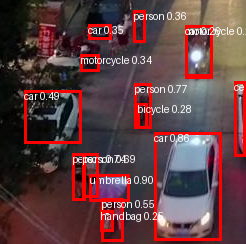

Cropped Image 2


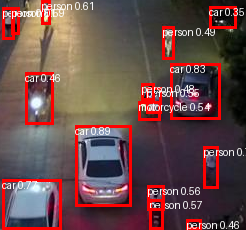

Cropped Image 3


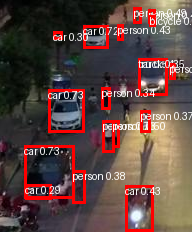

Cropped Image 4


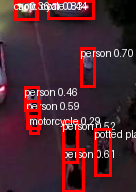

In [ ]:
#SARSA WITH GLSAN
import torch
from PIL import Image, ImageDraw
from IPython.display import display, Image as IPImage
import numpy as np
from sklearn.cluster import KMeans

# Load your custom-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5:v7.0', 'custom', path='/content/drive/MyDrive/yolov5/yolov5x.pt')

def draw_boxes_on_image(image, boxes, class_names, scores):
    draw = ImageDraw.Draw(image)
    for box, class_name, score in zip(boxes, class_names, scores):
        box = [int(coord) for coord in box]
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{class_name} {score:.2f}", fill="white")

def self_adaptive_crop(image_path):
    image = Image.open(image_path).convert("RGB")
    results = model(image)
    bboxes = results.xyxy[0][:, :4].cpu().numpy()
    scores = results.xyxy[0][:, 4].cpu().numpy()
    boxes_with_scores = np.column_stack((bboxes, scores))

    # Use self-adaptive cropping method
    centers, ranges = cluster_by_boxes_centers(4, image.size, boxes_with_scores)
    cropped_images = []

    for center, range in zip(centers, ranges):
        part_x1, part_y1, part_x2, part_y2 = transfrom_offsets(center, range, image.size[1], image.size[0])
        cropped_region = image.crop((part_x1, part_y1, part_x2, part_y2))
        cropped_images.append((cropped_region, center, range))

    return cropped_images

def process_and_display_output(cropped_images):
    for idx, (cropped_image, center, range) in enumerate(cropped_images):
        # Perform inference on the cropped image
        results = model(cropped_image)

        # Get the detected objects with bounding boxes, class names, and prediction scores
        detected_objects = []
        for det in results.xyxy[0]:
            class_id, score, bbox = int(det[5]), float(det[4]), det[:4]
            class_name = model.names[class_id]
            detected_objects.append({
                'class_name': class_name,
                'score': score,
                'bbox': bbox
            })

        # Draw bounding boxes on the cropped image
        draw_boxes_on_image(cropped_image, [obj['bbox'] for obj in detected_objects],
                            [obj['class_name'] for obj in detected_objects],
                            [obj['score'] for obj in detected_objects])

        # Display the original cropped image with bounding boxes
        print(f"Cropped Image {idx + 1}")
        display(cropped_image)

# Example usage
image_path = "/content/0000107_00891_d_0000052.jpg"
cropped_images = self_adaptive_crop(image_path)
process_and_display_output(cropped_images)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_v7.0
YOLOv5 🚀 2024-4-24 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Enhanced Cropped Image 1


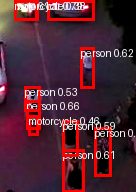

Enhanced Cropped Image 2


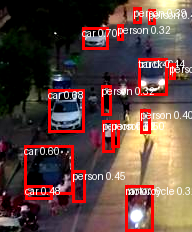

Enhanced Cropped Image 3


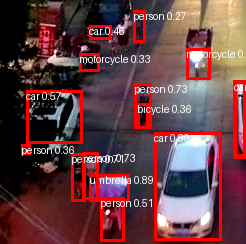

Enhanced Cropped Image 4


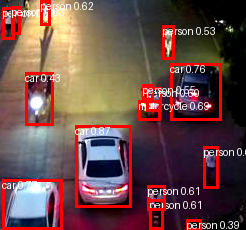

In [ ]:
import torch
from PIL import Image, ImageDraw, ImageEnhance
from IPython.display import display, Image as IPImage
import numpy as np
from sklearn.cluster import KMeans

# Load your custom-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5:v7.0', 'custom', path='/content/drive/MyDrive/yolov5/yolov5x.pt')

def draw_boxes_on_image(image, boxes, class_names, scores):
    draw = ImageDraw.Draw(image)
    for box, class_name, score in zip(boxes, class_names, scores):
        box = [int(coord) for coord in box]
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{class_name} {score:.2f}", fill="white")

def self_adaptive_crop(image_path):
    image = Image.open(image_path).convert("RGB")
    results = model(image)
    bboxes = results.xyxy[0][:, :4].cpu().numpy()
    scores = results.xyxy[0][:, 4].cpu().numpy()
    boxes_with_scores = np.column_stack((bboxes, scores))

    # Use self-adaptive cropping method
    centers, ranges = cluster_by_boxes_centers(4, image.size, boxes_with_scores)
    cropped_images = []

    for center, range in zip(centers, ranges):
        part_x1, part_y1, part_x2, part_y2 = transfrom_offsets(center, range, image.size[1], image.size[0])
        cropped_region = image.crop((part_x1, part_y1, part_x2, part_y2))

        # Apply histogram equalization to enhance the cropped region
        enhanced_cropped_region = enhance_image(cropped_region)

        cropped_images.append((enhanced_cropped_region, center, range))

    return cropped_images

def enhance_image(image):
    # Apply histogram equalization
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(1.5)  # Adjust the enhancement factor as needed
    return enhanced_image

def process_and_display_output(cropped_images):
    for idx, (cropped_image, center, range) in enumerate(cropped_images):
        # Perform inference on the enhanced cropped image
        results = model(cropped_image)

        # Get the detected objects with bounding boxes, class names, and prediction scores
        detected_objects = []
        for det in results.xyxy[0]:
            class_id, score, bbox = int(det[5]), float(det[4]), det[:4]
            class_name = model.names[class_id]
            detected_objects.append({
                'class_name': class_name,
                'score': score,
                'bbox': bbox
            })

        # Draw bounding boxes on the enhanced cropped image
        draw_boxes_on_image(cropped_image, [obj['bbox'] for obj in detected_objects],
                            [obj['class_name'] for obj in detected_objects],
                            [obj['score'] for obj in detected_objects])

        # Display the enhanced cropped image with bounding boxes
        print(f"Enhanced Cropped Image {idx + 1}")
        display(cropped_image)

# Example usage
image_path = "/content/0000107_00891_d_0000052.jpg"
cropped_images = self_adaptive_crop(image_path)
process_and_display_output(cropped_images)
